In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from device import Device
from loraextensor import LoRaExtensor
from lorawan import LoRaWAN
from loralong import LoRaLong

# Set device consumption characteristics
# https://www.semtech.com/products/wireless-rf/lora-connect/sx1262
sx1262 = Device()
sx1262.SetTxCurrent(118.0)          # 868~915 MHz/+22dBm
sx1262.SetRxCurrent(5.3)            # DCDC Mode/Rx Boosted, LoRa, 125Hz
sx1262.SetIdleCurrent(0.6)          # RC mode/XOSC off
sx1262.SetSleepCurrent(0.0012)      # Sleep with warm start/RC64k
sx1262.SetVoltage(3.3)

generateImages = 0

sf = 10
bw = 125
cr = 1
pkt = 100

In [43]:
perS = 60*60*6
simDurationH = 24*365*10
simDuration = simDurationH * 60*60

sf_wan = sf
bw_wan = bw
cr_wan = cr
pkt_wan = pkt + 8
ry_lorawan = LoRaWAN(pkt_wan, sf_wan, bw_wan, cr_wan)

sf_lng = sf
bw_lng = bw
cr_lng = cr
pkt_lng = pkt
ry_long = LoRaLong(pkt_lng, sf_lng, bw_lng, cr_lng)

print("loRa Extensor Comparison - relay uplink simulation")
print("Device Consumption x Application Uplink Periodicity")
print("Simulation Duration [y]:", simDurationH/(24*365))

ry_lorawan_TxTime_array = []
ry_lorawan_RxTime_array = []
ry_lorawan_SleepTime_array = []
ry_lorawan_TxCurr_array = []
ry_lorawan_RxCurr_array = []
ry_lorawan_SleepCurr_array = []
ry_lorawan_TotalMeanCon_array = []

ry_long_TxTime_array = []
ry_long_RxTime_array = []
ry_long_SleepTime_array = []
ry_long_TxCurr_array = []
ry_long_RxCurr_array = []
ry_long_SleepCurr_array = []
ry_long_TotalMeanCon_array = []

N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for n in N:

    txTime, rxTime, idleTime, sleepTime = ry_lorawan.SimulateRelayConfirmedLoRaWAN(perS, pkt_wan, simDuration, n)
    totalTime = txTime + rxTime + idleTime + sleepTime
    ry_lorawan_TxTime_array.append((txTime/totalTime)*100)
    ry_lorawan_RxTime_array.append((rxTime/totalTime)*100)
    ry_lorawan_SleepTime_array.append((sleepTime/totalTime)*100)
    total_mAh, tx_mAh, rx_mAh, idle_mAh, sleep_mAh = sx1262.GetAppConsumption(totalTime, txTime, rxTime, idleTime, sleepTime)
    ry_lorawan_TxCurr_array.append((tx_mAh/total_mAh)*100)
    ry_lorawan_RxCurr_array.append((rx_mAh/total_mAh)*100)
    ry_lorawan_SleepCurr_array.append((sleep_mAh/total_mAh)*100)
    ry_lorawan_TotalMeanCon_array.append((total_mAh/(totalTime/3600))*1000)

    txTime, rxTime, idleTime, sleepTime = ry_long.SimulateRelayLoRaLong(perS, pkt_lng, simDuration, n)
    totalTime = txTime + rxTime + idleTime + sleepTime
    ry_long_TxTime_array.append((txTime/totalTime)*100)
    ry_long_RxTime_array.append((rxTime/totalTime)*100)
    ry_long_SleepTime_array.append((sleepTime/totalTime)*100)
    total_mAh, tx_mAh, rx_mAh, idle_mAh, sleep_mAh = sx1262.GetAppConsumption(totalTime, txTime, rxTime, idleTime, sleepTime)
    ry_long_TxCurr_array.append((tx_mAh/total_mAh)*100)
    ry_long_RxCurr_array.append((rx_mAh/total_mAh)*100)
    ry_long_SleepCurr_array.append((sleep_mAh/total_mAh)*100)
    ry_long_TotalMeanCon_array.append((total_mAh/(totalTime/3600))*1000)


loRa Extensor Comparison - relay uplink simulation
Device Consumption x Application Uplink Periodicity
Simulation Duration [y]: 10.0


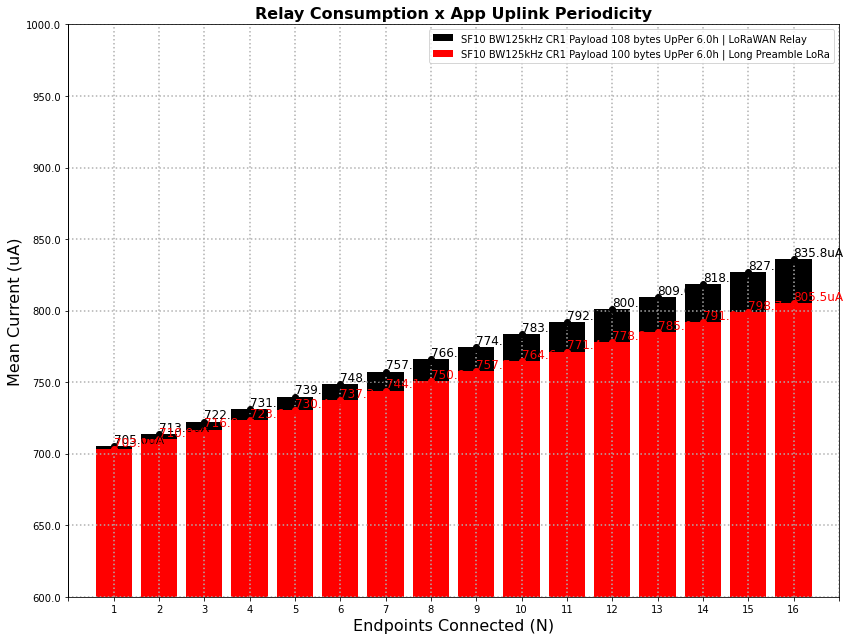

In [58]:
eixo_x = N
eixo_y1 = ry_lorawan_TotalMeanCon_array
eixo_y2 = ry_long_TotalMeanCon_array

fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(eixo_x, eixo_y1, color='black', linewidth=2, \
        label=f'SF{sf} BW{bw}kHz CR{cr} Payload {pkt_wan} bytes UpPer {perS/(60*60)}h | LoRaWAN Relay')
ax.bar(eixo_x, eixo_y2, color='red', linewidth=2, \
        label=f'SF{sf} BW{bw}kHz CR{cr} Payload {pkt_lng} bytes UpPer {perS/(60*60)}h | Long Preamble LoRa')
ax.set_title('Relay Consumption x App Uplink Periodicity', fontsize=16, weight='bold')
ax.set_xlabel('Endpoints Connected (N)', fontsize=16)
ax.set_ylabel('Mean Current (uA)', fontsize=16)
ax.set_ylim(600, 1000)
ax.set_xlim(0, 17)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '' if x == 0 or x == 17 else f'{int(x)}'))

for x_m in N:
    m_y1 = np.interp(x_m, eixo_x, eixo_y1)  # estima o y naquele x
    m_y2 = np.interp(x_m, eixo_x, eixo_y2)  # estima o y naquele x
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.plot(x_m, m_y1, marker='o', color='black', markersize=6)
    ax.text(x_m, m_y1, f'{m_y1:.1f}uA', fontsize=12, ha='left', va='bottom', color='black')
    ax.plot(x_m, m_y2, marker='o', color='red', markersize=6)
    ax.text(x_m, m_y2, f'{m_y2:.1f}uA', fontsize=12, ha='left', va='bottom', color='red')

ax.grid(True, which='both', linestyle=':', linewidth=1.5)
plt.legend()
plt.tight_layout()
if generateImages == 1:
    plt.savefig('ep_meanCurrXappPer.png', dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

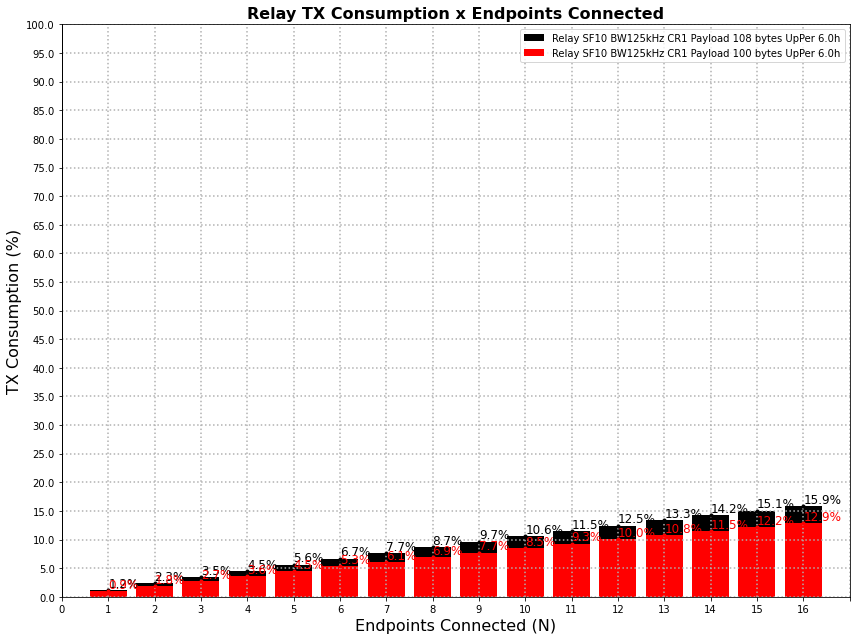

In [49]:
eixo_x = N
eixo_y1 = ry_lorawan_TxCurr_array
eixo_y2 = ry_long_TxCurr_array

fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(eixo_x, eixo_y1, color='black', linewidth=2, \
        label=f'Relay SF{sf} BW{bw}kHz CR{cr} Payload {pkt_wan} bytes UpPer {perS/(60*60)}h')
ax.bar(eixo_x, eixo_y2, color='red', linewidth=2, \
        label=f'Relay SF{sf} BW{bw}kHz CR{cr} Payload {pkt_lng} bytes UpPer {perS/(60*60)}h')
ax.set_title('Relay TX Consumption x Endpoints Connected', fontsize=16, weight='bold')
ax.set_xlabel('Endpoints Connected (N)', fontsize=16)
ax.set_ylabel('TX Consumption (%)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, 17)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '' if x == -1 or x == 17 else f'{int(x)}'))

for x_m in N:
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    y1_m = np.interp(x_m, eixo_x, eixo_y1)  # estima o y naquele x
    y2_m = np.interp(x_m, eixo_x, eixo_y2)  # estima o y naquele x
    ax.plot(x_m, y1_m, marker='.', color='black', markersize=6)
    ax.plot(x_m, y2_m, marker='.', color='red', markersize=6)
    ax.text(x_m, y1_m, f'{y1_m:.1f}%', fontsize=12, ha='left', va='bottom', color='black')
    ax.text(x_m, y2_m, f'{y2_m:.1f}%', fontsize=12, ha='left', va='bottom', color='red')

ax.grid(True, which='both', linestyle=':', linewidth=1.5)
plt.legend()
plt.tight_layout()
if generateImages == 1:
    plt.savefig('rl_txConsXn.png', dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

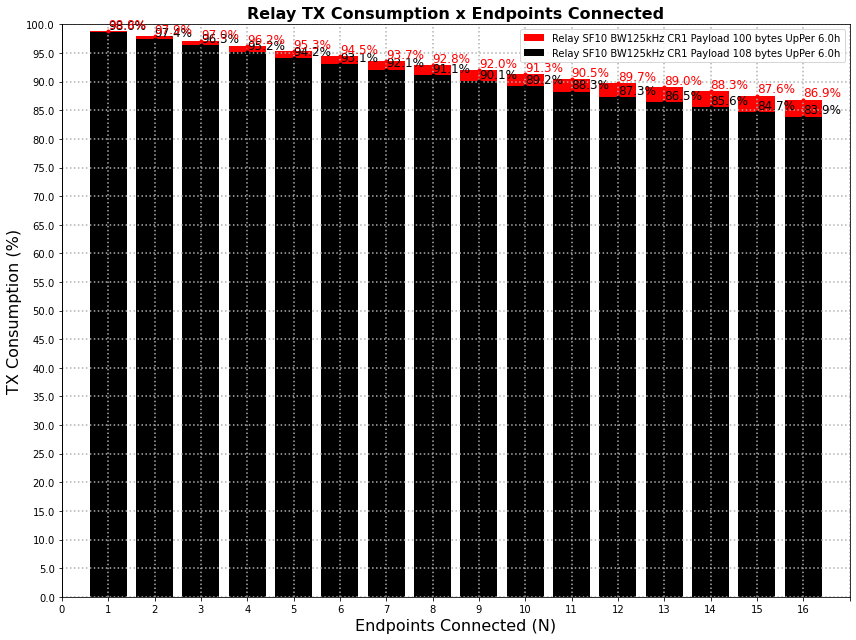

In [ ]:
eixo_x = N
eixo_y1 = ry_lorawan_RxCurr_array
eixo_y2 = ry_long_RxCurr_array

fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(eixo_x, eixo_y2, color='red', linewidth=2, \
        label=f'Relay SF{sf} BW{bw}kHz CR{cr} Payload {pkt_lng} bytes UpPer {perS/(60*60)}h')
ax.bar(eixo_x, eixo_y1, color='black', linewidth=2, \
        label=f'Relay SF{sf} BW{bw}kHz CR{cr} Payload {pkt_wan} bytes UpPer {perS/(60*60)}h')
ax.set_title('Relay RX Consumption x Endpoints Connected', fontsize=16, weight='bold')
ax.set_xlabel('Endpoints Connected (N)', fontsize=16)
ax.set_ylabel('RX Consumption (%)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, 17)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '' if x == -1 or x == 17 else f'{int(x)}'))

for x_m in N:
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    y1_m = np.interp(x_m, eixo_x, eixo_y1)  # estima o y naquele x
    y2_m = np.interp(x_m, eixo_x, eixo_y2)  # estima o y naquele x
    ax.plot(x_m, y1_m, marker='.', color='black', markersize=6)
    ax.plot(x_m, y2_m, marker='.', color='red', markersize=6)
    ax.text(x_m, y1_m, f'{y1_m:.1f}%', fontsize=12, ha='left', va='bottom', color='black')
    ax.text(x_m, y2_m, f'{y2_m:.1f}%', fontsize=12, ha='left', va='bottom', color='red')

ax.grid(True, which='both', linestyle=':', linewidth=1.5)
plt.legend()
plt.tight_layout()
if generateImages == 1:
    plt.savefig('rl_rxConsXn.png', dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
plt.show()